In [ ]:
import re

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):

    text = re.sub(r'[^\w\s]','',text, re.UNICODE)

    text = text.lower()#converting the text into all lower case

    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv("labeledTrainData.tsv",sep="\t")

In [ ]:
df

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
6187,8612_3,0,"This was a watchable movie, but plot was a lit..."
6188,9430_2,0,"I, too, was fooled by the packaging. I, too, f..."
6189,4075_1,0,I'm a horror/gore movie freak and this flick w...
6190,540_4,0,ALL FOR LOVE ( as it titled when it was broadc...


In [ ]:
df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))
df.head() #output

,id,sentiment,review,Processed_Reviews
0,5814_8,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,3630_4,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [ ]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean() #output

130.85497416020672

In [ ]:
from keras.preprocessing.text import Tokenizer #output from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten

from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D

from keras import initializers, regularizers, constraints, optimizers, layers


In [ ]:
max_features = 6000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])


In [ ]:
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
maxlen = 130

X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']


In [ ]:
embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 100

epochs = 3

model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/3
200/200 [==============================] - 62s 198ms/step - loss: 0.5548 - accuracy: 0.7039 - val_loss: 0.3136 - val_accuracy: 0.8666
Epoch 2/3
200/200 [==============================] - 38s 192ms/step - loss: 0.2230 - accuracy: 0.9147 - val_loss: 0.3398 - val_accuracy: 0.8628
Epoch 3/3
200/200 [==============================] - 39s 194ms/step - loss: 0.1645 - accuracy: 0.9433 - val_loss: 0.3416 - val_accuracy: 0.8654


In [ ]:
df_test=pd.read_csv("testData.tsv",header=0, delimiter="\t", quoting=3)

In [ ]:
df_test.head() #output
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))

df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [ ]:
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test =tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction =model.predict(X_te)
y_pred = (prediction > 0.5)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


F1-score: 0.0025567273889421545
Confusion matrix:


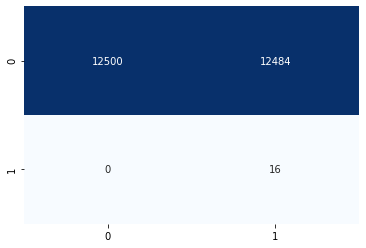

In [ ]:
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
cm=confusion_matrix(y_pred, y_test)
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         768000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 965,761
Trainable params: 965,761
Non-trainable params: 0
_________________________________________________________________


F1-score: 0.8576279408197913
Confusion matrix:


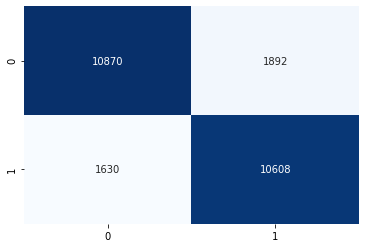

In [ ]:
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
cm=confusion_matrix(y_pred, y_test)
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)


In [ ]:
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

NameError: ignored